In [20]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["font.family"] = "serif"
import seaborn as sns
import os
import datetime as dt
# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [2]:
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
import joblib

In [3]:
def read_merged(weather, year):
    return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
lightning = [read_merged("lightning", year) for year in range(2015, 2024)]
light = pd.concat(lightning)
del lightning
del light['Month'], light['Event Month']


/tmp/ipykernel_6658/3179818135.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_6658/3179818135.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_6658/3179818135.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_6658/3179818135.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_6658/3179818135.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.

In [4]:
light['LOG_TOTAL_COUNT'] = np.log10(light['TOTAL_COUNT'])
light['DATE'] = pd.to_datetime(light['DATE'])
light['MONTH'] = light['DATE'].dt.month

In [6]:
light.columns

Index(['LON', 'LAT', 'TOTAL_COUNT', 'DATE', 'MONTH', 'COUNTY', 'STATE',
       'POWER_OUTAGE', 'CENTERLON', 'CENTERLAT', 'county', 'state',
       'power_outage', 'Event Month', 'LOG_TOTAL_COUNT'],
      dtype='object')

In [5]:
light = light[['LON', 'LAT', 'TOTAL_COUNT', 'MONTH', 'LOG_TOTAL_COUNT', 'POWER_OUTAGE']]

In [7]:
light.head()

,LON,LAT,TOTAL_COUNT,MONTH,LOG_TOTAL_COUNT,POWER_OUTAGE
0,-99.6,29.3,2,1,0.301030,False
1,-99.1,29.8,1,1,0.000000,False
2,-98.7,29.8,2,1,0.301030,False
3,-97.3,30.4,1,1,0.000000,False
4,-95.2,30.8,3,1,0.477121,False


In [5]:
light_train, light_test = train_test_split(light, test_size=0.2, stratify=light.POWER_OUTAGE, random_state=5)
light_tt, light_val = train_test_split(light_train, test_size=0.2, stratify=light_train.POWER_OUTAGE)
outage = light_tt[light_tt['POWER_OUTAGE']==True]
no_outage = light_tt[light_tt['POWER_OUTAGE']==False]
no_outage= no_outage.sample(n=len(outage), random_state=101)
balanced = pd.concat([outage,no_outage],axis=0)

In [11]:
xgb = joblib.load('../../models/xgb_lightning.pkl')
sgb = joblib.load('../../models/sgd_lightning.pkl')

In [12]:
xgb_clf = xgboost.XGBClassifier(objective= 'binary:logistic', learning_rate=0.1, max_depth=15, n_estimators=300)
rf_clf =  RandomForestClassifier(n_estimators=300, max_depth=13)
logistic_model = Pipeline([('scaler',StandardScaler()), ('logistic', LogisticRegression(C=0.1))])


In [20]:
balanced.columns

Index(['DATE', 'LAT', 'LON', 'STR_RANK_max', 'LL_ROT_VEL', 'LL_DV',
       'LL_BASE_max', 'DEPTH_KFT_max', 'DPTH_STMRL', 'MAX_RV_KFT_max',
       'MAX_RV_KTS', 'TVS', 'MSI', 'COUNTY', 'STATE', 'MONTH', 'POWER_OUTAGE',
       'Event Month'],
      dtype='object')

In [6]:
features_n = ['LON', 'LAT', 'MONTH', 'TOTAL_COUNT']
features = ['LON', 'LAT', 'MONTH', 'LOG_TOTAL_COUNT']

### If not saved

In [19]:
models = {'xgboost_v2': xgb_clf, 'RandomForest': rf_clf, 'LogisticRegression': logistic_model}
for name, model in models.items():
    model.fit(balanced[features], balanced['POWER_OUTAGE'])
    joblib.dump(model,'../../models/{}_lightning.pkl'.format(name))
    

## Once saved

In [7]:
xgb = joblib.load('../../models/xgb_lightning.pkl')
sgd = joblib.load('../../models/sgd_lightning.pkl')
xgb_y = joblib.load('../../models/xgboost_v2_lightning.pkl')
logistic = joblib.load('../../models/LogisticRegression_lightning.pkl')
rf = joblib.load('../../models/RandomForest_lightning.pkl')

In [8]:
models = {'xgboost':xgb, 'RandomForest':rf, 'xgboost_v2': xgb_y, 'LogisticRegression': logistic, 'stochastic_gd':sgd}

In [9]:
precisions, recalls, predictions ={}, {}, {}

In [10]:
for name, model in models.items():
    if name == 'xgboost_v2' or name == 'RandomForest' or name == 'LogisticRegression':
        preds = model.predict(light_val[features])
        predictions[name] = preds
        recalls[name] = recall_score(light_val['POWER_OUTAGE'], preds)
        precisions[name] = precision_score(light_val['POWER_OUTAGE'], preds)
        
    else:
        preds = model.predict(light_val[features_n])
        predictions[name] = preds
        precisions[name] = precision_score(light_val['POWER_OUTAGE'], preds)
        recalls[name] = recall_score(light_val['POWER_OUTAGE'], preds)



In [27]:
for name in models:
    print(f"Precision for {name} is {precisions[name]}")
    print(f"Recall for {name} is {recalls[name]}")

Precision for xgboost is 0.05584163955488323
Recall for xgboost is 0.9355755668872735
Precision for RandomForest is 0.04264699100760894
Recall for RandomForest is 0.9030270152978193
Precision for xgboost_v2 is 0.051058333742310724
Recall for xgboost_v2 is 0.9255723120321145
Precision for LogisticRegression is 0.017925922663182055
Recall for LogisticRegression is 0.6358251057827927
Precision for stochastic_gd is 0.016810748058564296
Recall for stochastic_gd is 0.7120104155365087


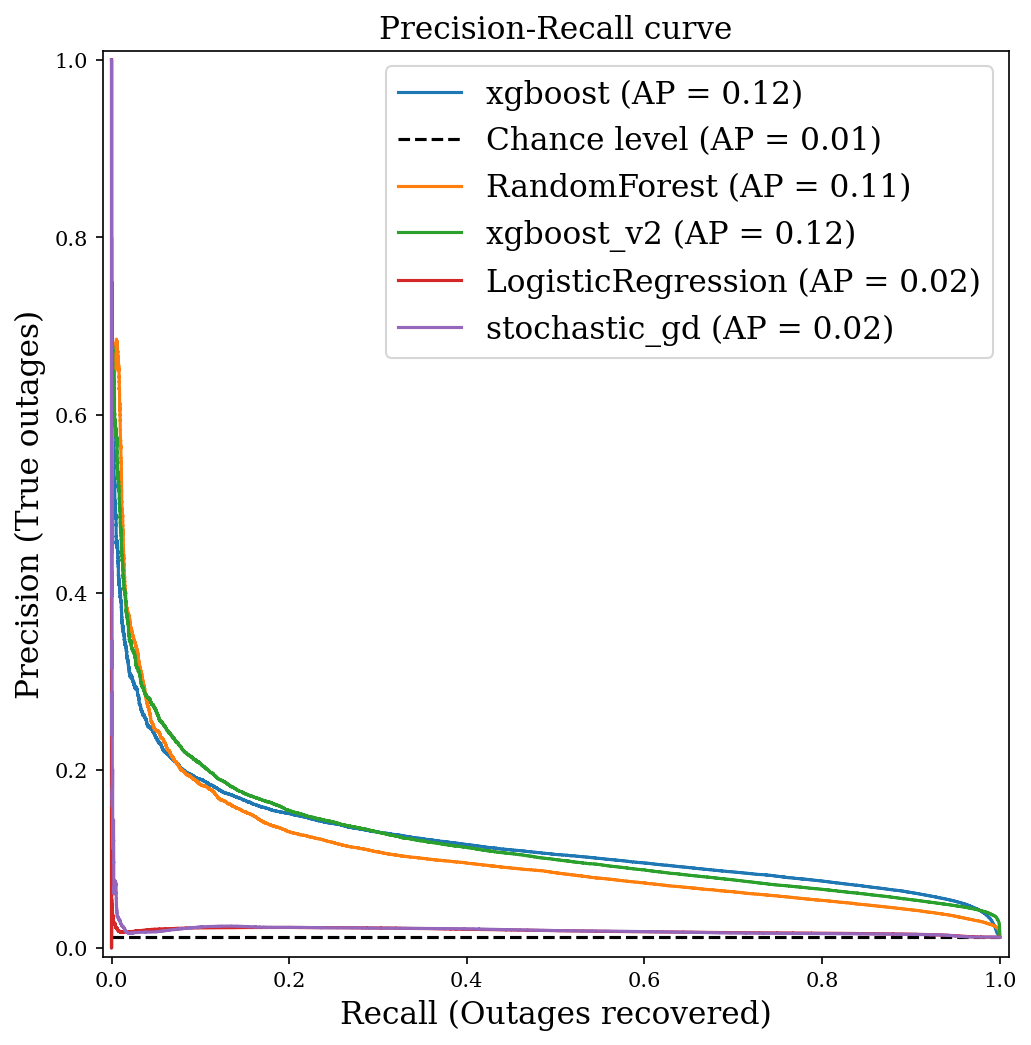

In [32]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
fig, ax = plt.subplots(figsize=(12, 8))
for name, model in models.items():
    if name == 'xgboost_v2' or name == 'RandomForest' or name == 'LogisticRegression':
        display = PrecisionRecallDisplay.from_estimator(
        model, light_val[features], light_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=ax, name=name)
    else:
        display = PrecisionRecallDisplay.from_estimator(
        model, light_val[features_n], light_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=ax, name=name)
_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      

plt.savefig("../../figures/lightning__model_comparison.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)
     


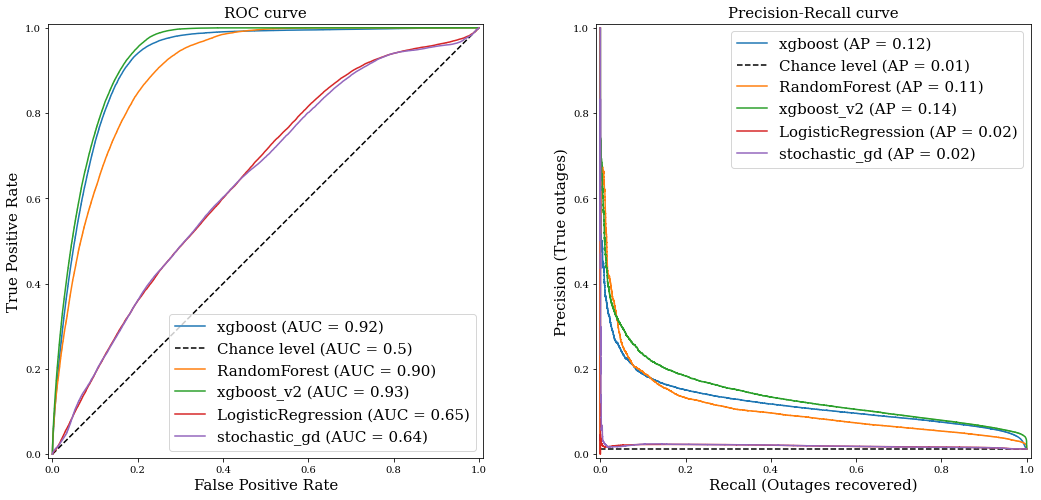

In [11]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
for name, model in models.items():
    if name == 'xgboost_v2' or name == 'RandomForest' or name == 'LogisticRegression':
        display = PrecisionRecallDisplay.from_estimator(
        model, light_val[features], light_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[1], name=name)
        display2 = RocCurveDisplay.from_estimator(
        model, light_val[features], light_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[0], name=name)
    else:
        display = PrecisionRecallDisplay.from_estimator(
        model, light_val[features_n], light_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[1], name=name)
        display2 = RocCurveDisplay.from_estimator(
        model, light_val[features_n], light_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=axs[0], name=name)
_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      


_ = display2.ax_.set_title("ROC curve", size=15)      
_ = display2.ax_.legend(loc='lower right', fontsize=15)      
_ = display2.ax_.set_xlabel('False Positive Rate', size=15)      
_ = display2.ax_.set_ylabel('True Positive Rate', size=15)

plt.savefig("../../figures/lightning_roc_pr_model_comparison.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)



# Results on test

In [12]:
best_model = models['xgboost_v2']

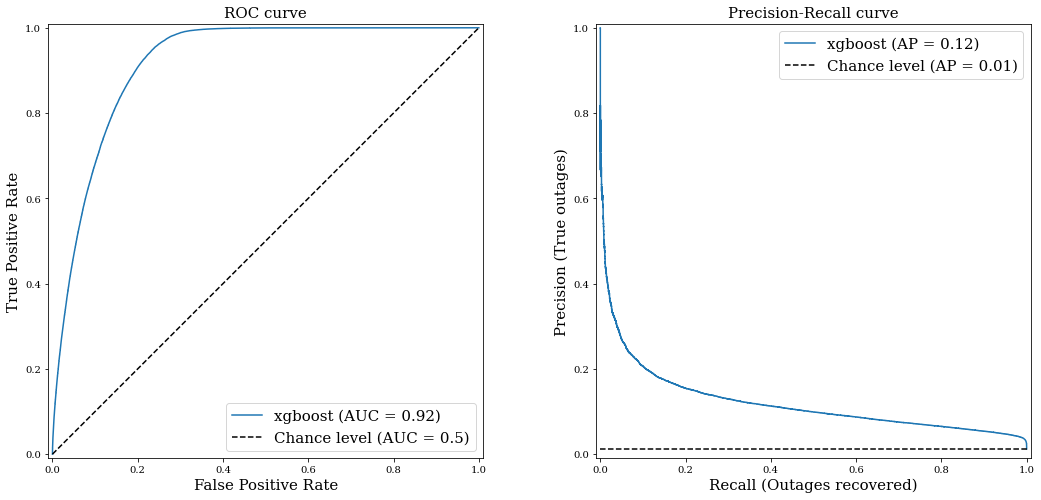

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
display = PrecisionRecallDisplay.from_estimator(
        best_model, light_test[features], light_test['POWER_OUTAGE'], 
            plot_chance_level=True, ax=axs[1], name='xgboost')
display2 = RocCurveDisplay.from_estimator(
        best_model, light_test[features], light_test['POWER_OUTAGE'], 
            plot_chance_level=True, ax=axs[0], name='xgboost')

_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      


_ = display2.ax_.set_title("ROC curve", size=15)      
_ = display2.ax_.legend(loc='lower right', fontsize=15)      
_ = display2.ax_.set_xlabel('False Positive Rate', size=15)      
_ = display2.ax_.set_ylabel('True Positive Rate', size=15)

plt.savefig("../../figures/lightning_roc_pr_test_results.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)

# Feature importance

In [33]:
best_model = models['xgboost_v2']
best_model.get_booster().get_score(importance_type='gain')

{'LON': 5.684155464172363,
 'LAT': 4.2135772705078125,
 'MONTH': 10.605623245239258,
 'LOG_TOTAL_COUNT': 1.78622567653656}

# Confusion Matrix

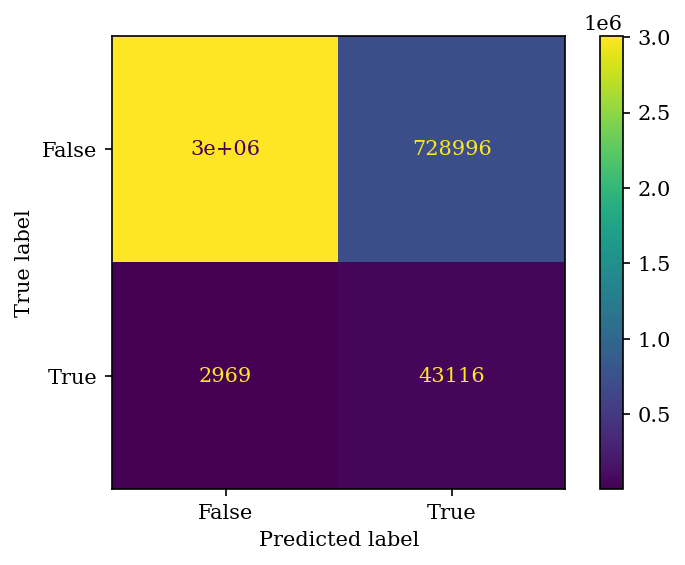

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(light_val['POWER_OUTAGE'], predictions['xgboost'])

# Confusion matrix with a different threshold

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
probas = best_model.predict_proba(light_test[features])

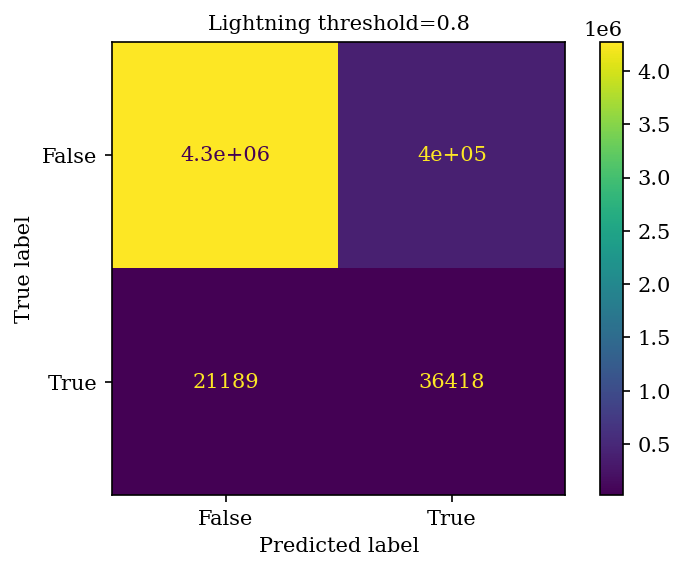

In [22]:
thr = 0.8
display = ConfusionMatrixDisplay.from_predictions(light_test['POWER_OUTAGE'], probas[:,1]>thr)
_ = display.ax_.set_title("Lightning threshold={}".format(thr), size=10)      
plt.savefig("../../figures/light_confusion_matrix_thr_{:1.0f}.png".format(10*thr), dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)